In [13]:
#!pip3 install autokeras
#!pip3 install matplotlib

In [14]:
import numpy as np
import pandas as pd
import tensorflow as tf

import logging
logging.getLogger('tensorflow').disabled = True

from sklearn.datasets import load_files
from tensorflow.keras.datasets import mnist
import autokeras as ak
from tensorflow.keras.models import load_model

import copy 
import os
import json

import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc, precision_recall_curve, roc_auc_score, average_precision_score
from sklearn.datasets import make_classification
from plotly.subplots import make_subplots

from mylib import plot_roc, plot_pr_curve, plot_roc_train_test, plot_pr_train_test, hyper_table, predic_error_analysis, plot_pr_multi_class

In [15]:
n_gpu = len(tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", n_gpu)
if n_gpu:
    ! nvidia-smi

Num GPUs Available:  1
Wed May  5 06:21:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA Tesla T4     On   | 00000000:00:1E.0 Off |                    0 |
| N/A   26C    P8     8W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                 

## A Simple Example
The first step is to prepare your data. Here we use the MNIST dataset as an example


The second step is to run the ImageClassifier.
It is recommended have more trials for more complicated datasets.
This is just a quick demo of MNIST, so we set max_trials to 1.
For the same reason, we set epochs to 10.
You can also leave the epochs unspecified for an adaptive number of epochs.


In [16]:
data = pd.read_csv('new_multiclasses.csv')
data = data[data['mos1'] > 0]

mos1_Y = np.arange(start=0.5, stop=1.0, step=0.05)
mos1_Y = [round(x, 2) for x in mos1_Y]

Y_mos1 = [mos1_Y[np.argmax(np.array(x) < mos1_Y)] for x in data['mos1']]
data['Y_mos1'] = ['mos1_'+str(x) for x in Y_mos1]
data

,file,blank,ps1,ps2,multi,ice,badice,mos1,mos2,Y,Y_mos1
0,fake_00001.pgm,0,1,0,0,1,0,0.892528,0.000000,ps1+ice,mos1_0.9
1,fake_00002.pgm,0,0,1,1,0,0,0.581729,0.568217,ps2+multi,mos1_0.6
2,fake_00003.pgm,0,1,0,0,0,0,0.508285,0.000000,ps1,mos1_0.55
3,fake_00004.pgm,0,1,0,0,0,0,0.852589,0.000000,ps1,mos1_0.9
4,fake_00005.pgm,0,0,1,0,0,0,0.762097,0.000000,ps2,mos1_0.8
...,...,...,...,...,...,...,...,...,...,...,...
26573,fake_38737.pgm,0,1,0,0,0,0,0.897076,0.000000,ps1,mos1_0.9
26574,fake_38738.pgm,0,1,0,0,0,0,0.646006,0.000000,ps1,mos1_0.65
26575,fake_38740.pgm,0,1,1,1,0,0,0.529205,0.716043,ps1+ps2+multi,mos1_0.55
26576,fake_38741.pgm,0,1,0,0,0,0,0.752521,0.000000,ps1,mos1_0.8


In [17]:
lable_count = dict(data['Y'].value_counts())
lable_count

{'ps1': 9611,
 'ps1+ps2+multi': 5142,
 'ps2+multi': 2558,
 'ps1+multi': 2550,
 'ps1+ice': 1624,
 'ps2+ice': 1612,
 'ps2': 1589,
 'ps1+ps2+multi+ice': 869,
 'ps2+multi+ice': 420,
 'ps1+multi+ice': 397,
 'ps1+ps2': 75,
 'ps1+ps2+ice': 26,
 'ps2+ice+badice': 13,
 'ps1+ice+badice': 7,
 'ps2+multi+ice+badice': 4,
 'ps1+multi+ice+badice': 2,
 'ps1+ps2+multi+ice+badice': 2}

In [18]:
new_data = pd.concat([data[data['Y']==y][:100] if lable_count[y]>100 else data[data['Y']==y] for y in np.unique(data['Y'])])
new_data

,file,blank,ps1,ps2,multi,ice,badice,mos1,mos2,Y,Y_mos1
2,fake_00003.pgm,0,1,0,0,0,0,0.508285,0.000000,ps1,mos1_0.55
3,fake_00004.pgm,0,1,0,0,0,0,0.852589,0.000000,ps1,mos1_0.9
7,fake_00008.pgm,0,1,0,0,0,0,0.626877,0.000000,ps1,mos1_0.65
11,fake_00012.pgm,0,1,0,0,0,0,0.597623,0.000000,ps1,mos1_0.6
12,fake_00013.pgm,0,1,0,0,0,0,0.704936,0.000000,ps1,mos1_0.75
...,...,...,...,...,...,...,...,...,...,...,...
6019,fake_08555.pgm,0,0,1,1,1,0,0.850695,0.815657,ps2+multi+ice,mos1_0.9
13,fake_00014.pgm,0,0,1,1,1,1,0.516343,0.681703,ps2+multi+ice+badice,mos1_0.55
46,fake_00047.pgm,0,0,1,1,1,1,0.822762,0.710859,ps2+multi+ice+badice,mos1_0.85
114,fake_00115.pgm,0,0,1,1,1,1,0.603269,0.832699,ps2+multi+ice+badice,mos1_0.65


In [19]:
imgs = []
imgs_arr = []
imgs_drop = []
for f in new_data['file']:
    f = f.replace('pgm','png')
    try:
        image = tf.keras.preprocessing.image.load_img("./training_data/{}".format(f), color_mode='grayscale') 
        image_array = tf.keras.preprocessing.image.img_to_array(image)
        imgs.append(image)
        imgs_arr.append(image_array)
    except:
        imgs_drop.append(f)
print(len(imgs_drop))

0


In [20]:
input_arr = np.array(imgs_arr)  # Convert single image to a batch.
print(type(input_arr))
print(input_arr.shape)
x_train = np.squeeze(input_arr)
print(x_train.shape)
y_train = np.array(new_data['Y_mos1'])
print(y_train.shape)
X = x_train
Y = y_train

<class 'numpy.ndarray'>
(1129, 512, 512, 1)
(1129, 512, 512)
(1129,)


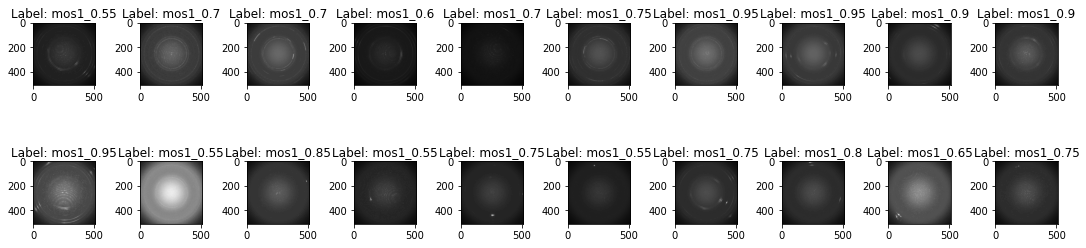

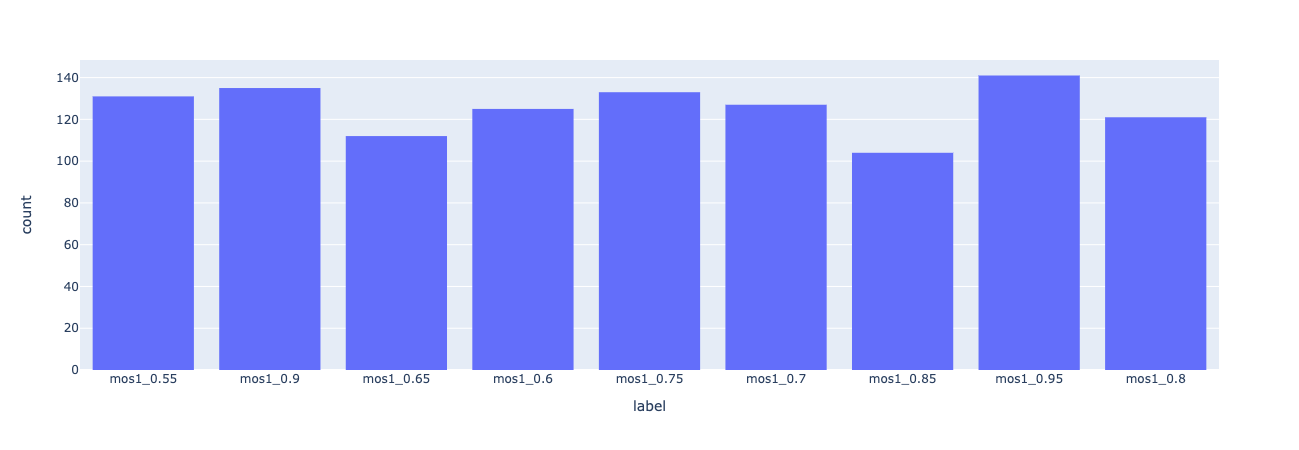

In [21]:
import matplotlib.pyplot as plt
num = 20
k=np.random.randint(len(y_train))
images = x_train[k:(k+num)]
labels = y_train[k:(k+num)]
num_row = 2
num_col = 10
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i], cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))
plt.tight_layout()
plt.show()

import plotly.express as px
df = pd.DataFrame(y_train, columns=['label'])
fig = px.histogram(df, x='label', nbins=10)
fig.show()

In [22]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [23]:
PATH='image_classifier4'

In [24]:
# Initialize the image classifier.
clf = ak.ImageClassifier(overwrite=True, directory=PATH, max_trials=10)

# Feed the image classifier with training data. That's it!
clf.fit(x_train, y_train, batch_size=16)

Trial 10 Complete [00h 55m 55s]
val_loss: 2.152095317840576

Best val_loss So Far: 2.152095317840576
Total elapsed time: 07h 32m 56s
Epoch 1/4
Not enough memory, reduce batch size to 8.
Epoch 1/4
Not enough memory, reduce batch size to 4.
Epoch 1/4
226/226 [==============================] - 271s 1s/step - loss: 2.2058 - accuracy: 0.1251
Epoch 2/4
226/226 [==============================] - 271s 1s/step - loss: 2.1020 - accuracy: 0.2259
Epoch 3/4
226/226 [==============================] - 270s 1s/step - loss: 1.9775 - accuracy: 0.3178
Epoch 4/4
226/226 [==============================] - 270s 1s/step - loss: 1.8255 - accuracy: 0.3721


In [25]:
# Predict with the best model.
predicted_y = clf.predict(x_test)
#print(predicted_y)


# Evaluate the best model with testing data.
print(clf.evaluate(x_test, y_test))

8/8 [==============================] - 16s 2s/step - loss: 2.3413 - accuracy: 0.1062
[2.341315507888794, 0.10619468986988068]


In [26]:
# performance of the model
model = clf.export_model()

In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512)]   0                                            
__________________________________________________________________________________________________
cast_to_float32 (CastToFloat32) (None, 512, 512)     0           input_1[0][0]                    
__________________________________________________________________________________________________
expand_last_dim (ExpandLastDim) (None, 512, 512, 1)  0           cast_to_float32[0][0]            
__________________________________________________________________________________________________
normalization (Normalization)   (None, 512, 512, 1)  3           expand_last_dim[0][0]            
______________________________________________________________________________________________

In [28]:
display(hyper_table(path=PATH+'/image_classifier'))

,trial#1,trial#2,trial#3,trial#4,trial#5,trial#6,trial#7,trial#8,trial#9,trial#10
image_block_1/normalize,True,True,True,True,True,True,True,True,True,True
image_block_1/augment,True,True,True,False,True,True,True,True,True,True
image_block_1/block_type,efficient,efficient,efficient,vanilla,efficient,efficient,efficient,efficient,resnet,efficient
classification_head_1/spatial_reduction_1/reduction_type,global_avg,global_avg,global_avg,flatten,global_avg,global_avg,global_avg,global_avg,global_avg,global_avg
classification_head_1/dropout,0,0,0,0.5,0,0,0,0,0,0
optimizer,adam,adam,adam,adam,adam,adam,adam,adam,adam,adam
learning_rate,2e-05,2e-05,2e-05,0.001,0.0001,2e-05,2e-05,2e-05,0.001,0.01
image_block_1/image_augmentation_1/translation_factor,0.1,0.1,0.1,NaN,0.1,0,0.1,0.1,0.1,0.1
image_block_1/image_augmentation_1/horizontal_flip,True,True,True,NaN,True,True,True,True,True,True
image_block_1/image_augmentation_1/vertical_flip,False,False,False,NaN,False,False,False,False,True,False


### Upload the trained model to google cloud storage

In [29]:
try:
    model.save(PATH+"/trained_model", save_format="tf")
except Exception:
    model.save(PATH+"/trained_model.h5")
    
os.system("gsutil -m cp -r {0}/trained_model gs://diffraction-ai/trained_model/{0}/".format(PATH))

32512

In [30]:
loaded_model = load_model(PATH+"/trained_model", custom_objects=ak.CUSTOM_OBJECTS)

In [31]:
loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512)]   0                                            
__________________________________________________________________________________________________
cast_to_float32 (CastToFloat32) (None, 512, 512)     0           input_1[0][0]                    
__________________________________________________________________________________________________
expand_last_dim (ExpandLastDim) (None, 512, 512, 1)  0           cast_to_float32[0][0]            
__________________________________________________________________________________________________
normalization (Normalization)   (None, 512, 512, 1)  3           expand_last_dim[0][0]            
______________________________________________________________________________________________

In [32]:
y_score_test = loaded_model.predict(x_test)
y_score_train = loaded_model.predict(x_train)

In [33]:
def plot_pr_multi_class(y_train, y_score_train, y_test, y_score_test):
    w=900
    h=600
    # ROC PR curves for multi-class
    y_class = np.unique(y_train)
    class_dict_test = {}
    for c in y_class:
        score = [s[np.argmax(y_class == c)] for s in y_score_test]
        obs = y_test == c
        class_dict_test[c] = {'obs': obs, 'score': score}

    class_dict_train = {}
    for c in y_class:
        score = [s[np.argmax(y_class == c)] for s in y_score_train]
        obs = y_train == c
        class_dict_train[c] = {'obs': obs, 'score': score}

    fig = make_subplots(rows=1, cols=1)

    # subplot for ROC curve: train data
    fig.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0, x1=1, y0=0, y1=1,
        row=1, col=1)

    Y_Scores = [class_dict_train[c]['score'] for c in class_dict_train]
    Y_Obs = [class_dict_train[c]['obs'] for c in class_dict_train]
    Y_Names = y_class
    class2auc = {}
    for i in range(len(Y_Scores)):
        y_true = Y_Obs[i]
        y_score = Y_Scores[i]

        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc_score = roc_auc_score(y_true, y_score)
        if not np.isnan(auc_score):
            class2auc[Y_Names[i]] = auc_score
        name = f"class {Y_Names[i]} ROC: Train (AUC={auc_score:.4f})"
        fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'),row=1, col=1)

    class2count = dict(zip(Y_Names, [sum(obs) for obs in Y_Obs]))    
    class2weight = {}
    for c in class2auc:
        class2weight[c] = class2count[c]
    avg_auc = sum(np.array(list(class2auc.values())) * (np.array(list(class2weight.values()))/sum(class2weight.values())))

    fig.update_xaxes(title_text="False Positive Rate", row=1, col=1)
    fig.update_yaxes(title_text="True Positive Rate (Train)", row=1, col=1)
    fig.update_layout(title="Average ROC: {} (Training Data)".format(round(avg_auc,2)),
                     width=w, height=h)
    fig.show()

    fig = make_subplots(rows=1, cols=1)
    # subplot for ROC curve: train data
    fig.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0, x1=1, y0=0, y1=1,
        row=1, col=1)

    Y_Scores = [class_dict_test[c]['score'] for c in class_dict_test]
    Y_Obs = [class_dict_test[c]['obs'] for c in class_dict_test]
    Y_Names = y_class
    class2auc = {}
    for i in range(len(Y_Scores)):
        try:
            y_true = Y_Obs[i]
            y_score = Y_Scores[i]

            fpr, tpr, _ = roc_curve(y_true, y_score)
            auc_score = roc_auc_score(y_true, y_score)
            if not np.isnan(auc_score):
                class2auc[Y_Names[i]] = auc_score
            name = f"class {Y_Names[i]} ROC: Test (AUC={auc_score:.4f})"
            fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'),row=1, col=1)
        except:
            print("something wrong in {}".format(Y_Names[i]))

    class2count = dict(zip(Y_Names, [sum(obs) for obs in Y_Obs]))    
    class2weight = {}
    for c in class2auc:
        class2weight[c] = class2count[c]
    avg_auc = sum(np.array(list(class2auc.values())) * (np.array(list(class2weight.values()))/sum(class2weight.values())))

    fig.update_xaxes(title_text="False Positive Rate", row=1, col=1)
    fig.update_yaxes(title_text="True Positive Rate (Test)", row=1, col=1)
    fig.update_layout(title="Average ROC: {} (Testing Data)".format(round(avg_auc,2)),
                     width=w, height=h)
    fig.show()

    fig = make_subplots(rows=1, cols=1)
    # subplot for PR curve: train data
    fig.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0, x1=1, y0=1, y1=0, 
        row=1,col=1)
    Y_Scores = [class_dict_train[c]['score'] for c in class_dict_train]
    Y_Obs = [class_dict_train[c]['obs'] for c in class_dict_train]
    Y_Names = y_class
    class2auc = {}
    for i in range(len(Y_Scores)):
        try:
            y_true = Y_Obs[i]
            y_score = Y_Scores[i]
            precision, recall, _ = precision_recall_curve(y_true, y_score)
            auc_score = average_precision_score(y_true, y_score)
            if not np.isnan(auc_score):
                class2auc[Y_Names[i]] = auc_score
            name = f"class {Y_Names[i]} PR Train (AUC={auc_score:.4f})"
            fig.add_trace(go.Scatter(x=recall, y=precision, name=name, mode='lines'),row=1,col=1)
        except:
            print("something wrong in {}".format(Y_Names[i]))

    class2count = dict(zip(Y_Names, [sum(obs) for obs in Y_Obs]))    
    class2weight = {}
    for c in class2auc:
        class2weight[c] = class2count[c]
    avg_auc = sum(np.array(list(class2auc.values())) * (np.array(list(class2weight.values()))/sum(class2weight.values())))

    fig.update_xaxes(title_text="Recall", row=1, col=1)
    fig.update_yaxes(title_text="Precision (Train)", row=1, col=1)
    fig.update_layout(title="Average PR: {} (Training Data)".format(round(avg_auc,2)),
                     width=w, height=h)
    fig.show()

    fig = make_subplots(rows=1, cols=1)
    # subplot for PR curve: test data
    fig.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0, x1=1, y0=1, y1=0, 
        row=1,col=1)
    Y_Scores = [class_dict_test[c]['score'] for c in class_dict_test]
    Y_Obs = [class_dict_test[c]['obs'] for c in class_dict_test]
    Y_Names = y_class
    class2auc = {}
    for i in range(len(Y_Scores)):
        try:
            y_true = Y_Obs[i]
            y_score = Y_Scores[i]

            precision, recall, _ = precision_recall_curve(y_true, y_score)
            auc_score = average_precision_score(y_true, y_score)
            if not np.isnan(auc_score):
                class2auc[Y_Names[i]] = auc_score
                name = f"class {Y_Names[i]} PR Test (AUC={auc_score:.4f})"
                fig.add_trace(go.Scatter(x=recall, y=precision, name=name, mode='lines'),row=1,col=1)
        except:
            print("something wrong in {}".format(Y_Names[i]))
            
    class2count = dict(zip(Y_Names, [sum(obs) for obs in Y_Obs]))    
    class2weight = {}
    for c in class2auc:
        class2weight[c] = class2count[c]
    avg_auc = sum(np.array(list(class2auc.values())) * (np.array(list(class2weight.values()))/sum(class2weight.values())))

    fig.update_xaxes(title_text="Recall", row=1, col=1)
    fig.update_yaxes(title_text="Precision (Test)", row=1, col=1)
    fig.update_layout(title="Average PR: {} (Testing Data)".format(round(avg_auc,2)),
                     width=w, height=h)
    fig.show()

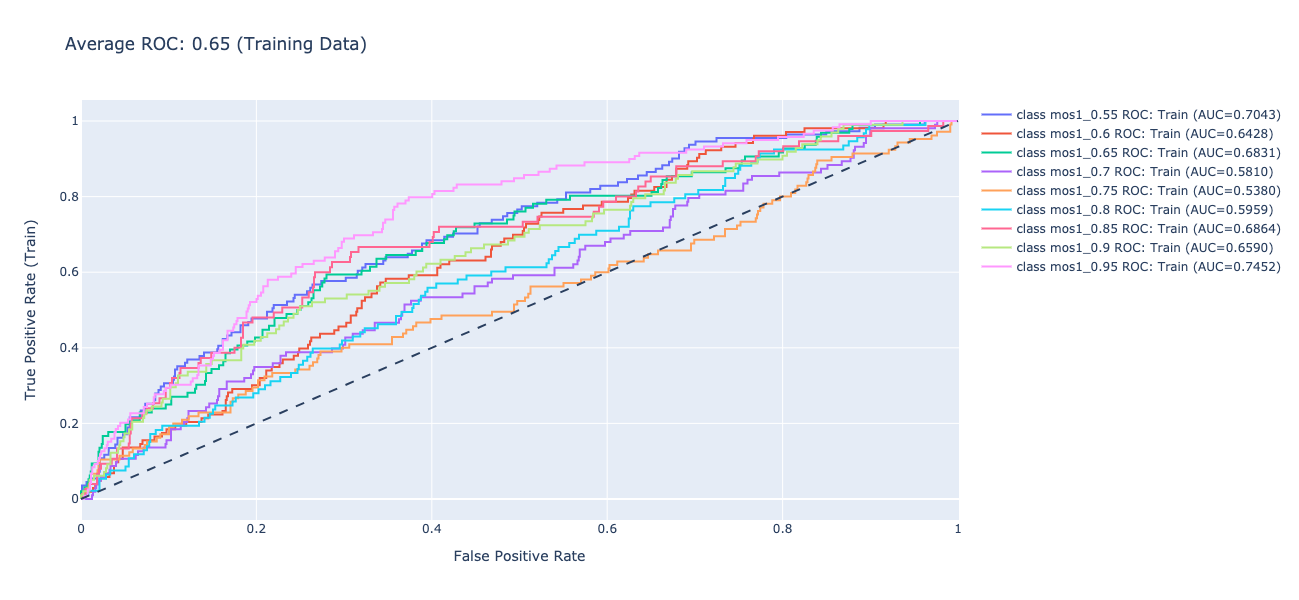

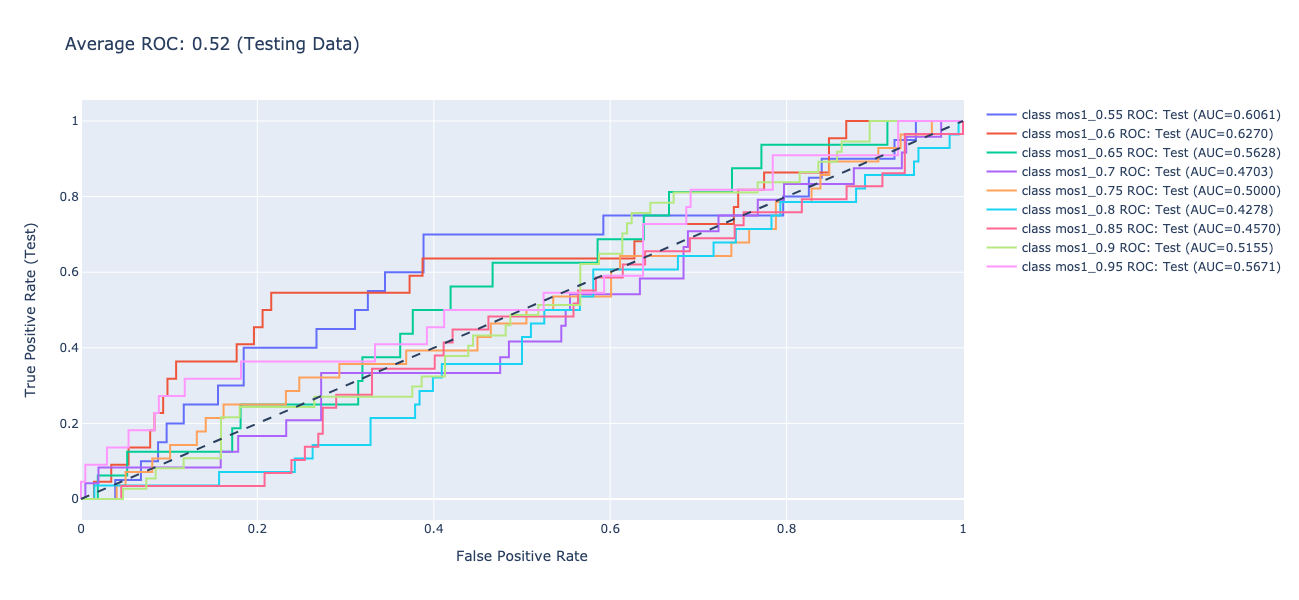

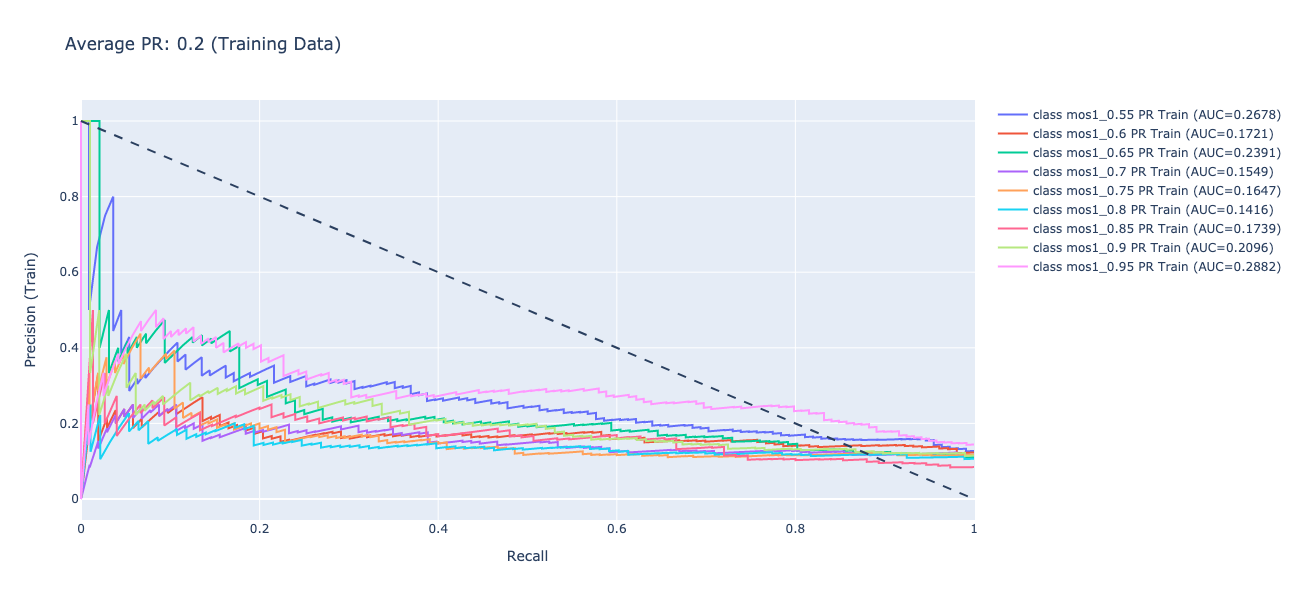

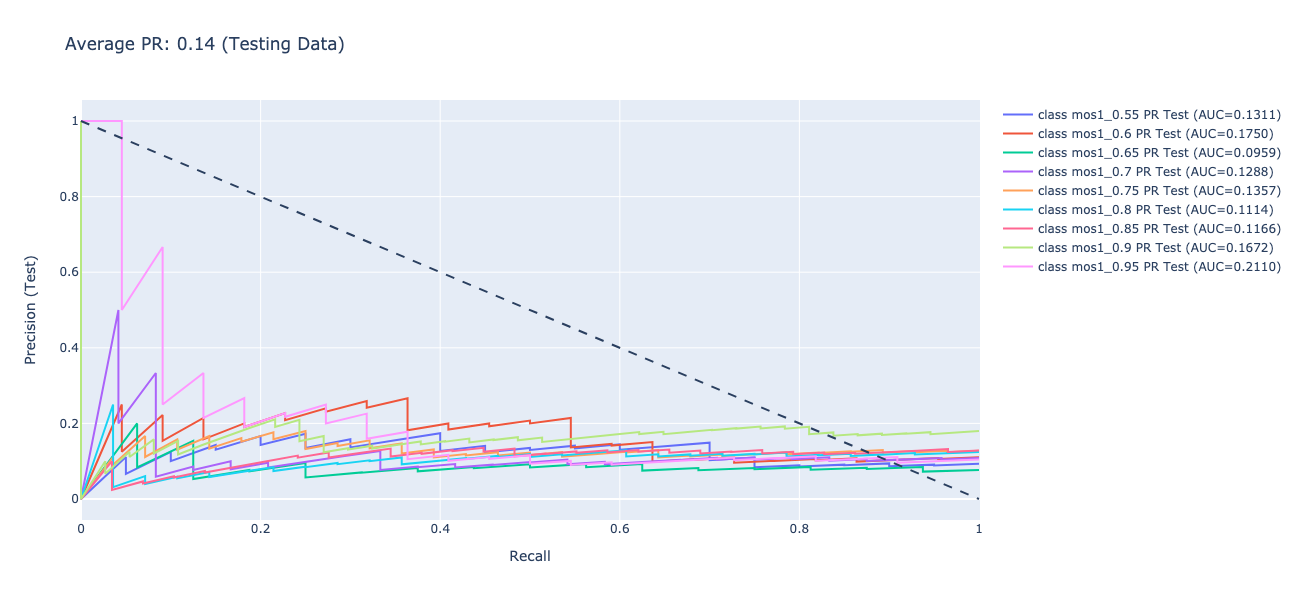

In [34]:
plot_pr_multi_class(y_train, y_score_train, y_test, y_score_test)

### Confusion Matrix (Testing Data)

In [35]:
labels=np.unique(y_train)
y_pred_test = [labels[np.argmax(p)] for p in y_score_test]

cm_df = pd.DataFrame(np.zeros((len(labels),len(labels))))
cm_df.columns = labels
cm_df.index = labels

for k in range(len(y_pred_test)):
    p = y_pred_test[k]
    t = y_test[k]
    cm_df.loc[t,p] = cm_df.loc[t,p] + 1 

#display(cm_df)

# normalize by each row to have the prediction accuracy on the diagonal
cm_df2 = cm_df.div(cm_df.sum(axis=1), axis=0) *100
cm_df2 = cm_df2.fillna(0)
#display(cm_df2)

avg_acc = sum(cm_df.sum(axis=0)/sum(cm_df.sum(axis=0)) * np.diag(cm_df2))

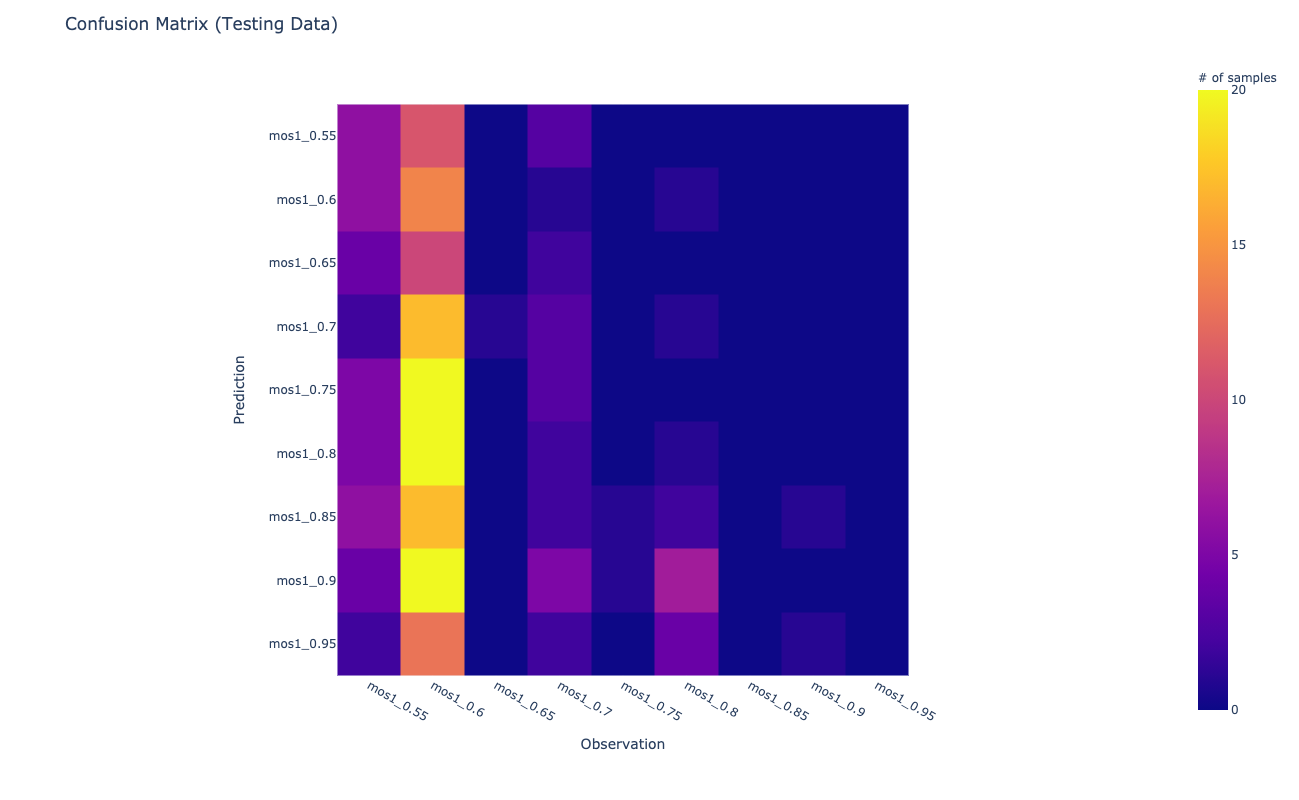

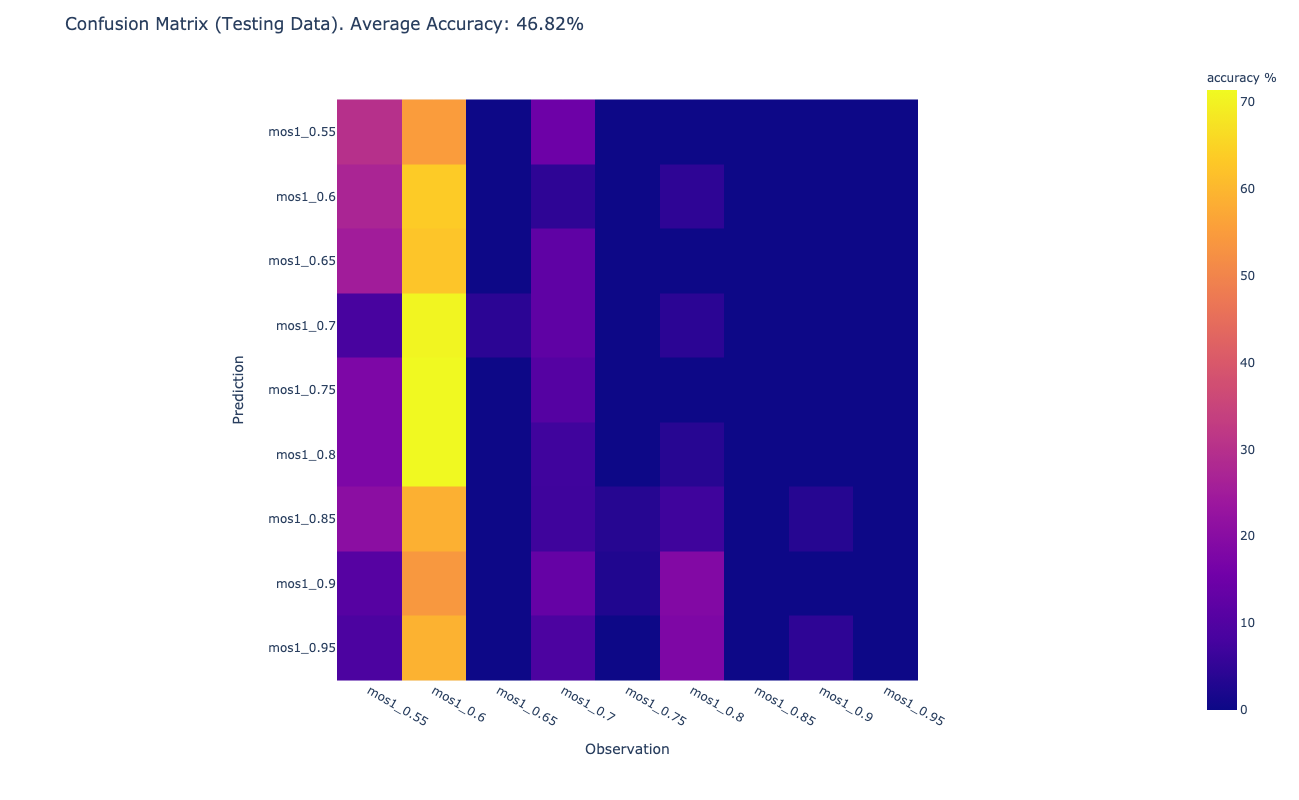

In [36]:
fig1 = px.imshow(cm_df, labels=dict(y="Prediction", x="Observation", color="# of samples"))
fig1.update_yaxes(dtick=1)
fig1.update_xaxes(dtick=1)
fig1.update_layout(title='Confusion Matrix (Testing Data)', width=800, height=800)
fig1.show()

fig2 = px.imshow(cm_df2, labels=dict(y="Prediction", x="Observation", color="accuracy %"))
fig2.update_yaxes(dtick=1)
fig2.update_xaxes(dtick=1)
fig2.update_layout(title='Confusion Matrix (Testing Data). Average Accuracy: {}%'.format(round(avg_acc,2)), width=800, height=800)
fig2.show()

### Confusion Matrix (Traning Data)

In [37]:
y_pred_train = [labels[np.argmax(p)] for p in y_score_train]

cm_train_df = pd.DataFrame(np.zeros((len(labels),len(labels))))
cm_train_df.columns = labels
cm_train_df.index = labels

for k in range(len(y_pred_train)):
    p = y_pred_train[k]
    t = y_train[k]
    cm_train_df.loc[t,p] = cm_train_df.loc[t,p] + 1 

#display(cm_train_df)

# normalize by each row to have the prediction accuracy on the diagonal
cm_train_df2 = cm_train_df.div(cm_train_df.sum(axis=1), axis=0) *100
cm_train_df2 = cm_train_df2.fillna(0)
#display(cm_train_df2)

avg_train_acc = sum(cm_train_df.sum(axis=0)/sum(cm_train_df.sum(axis=0)) * np.diag(cm_train_df2))

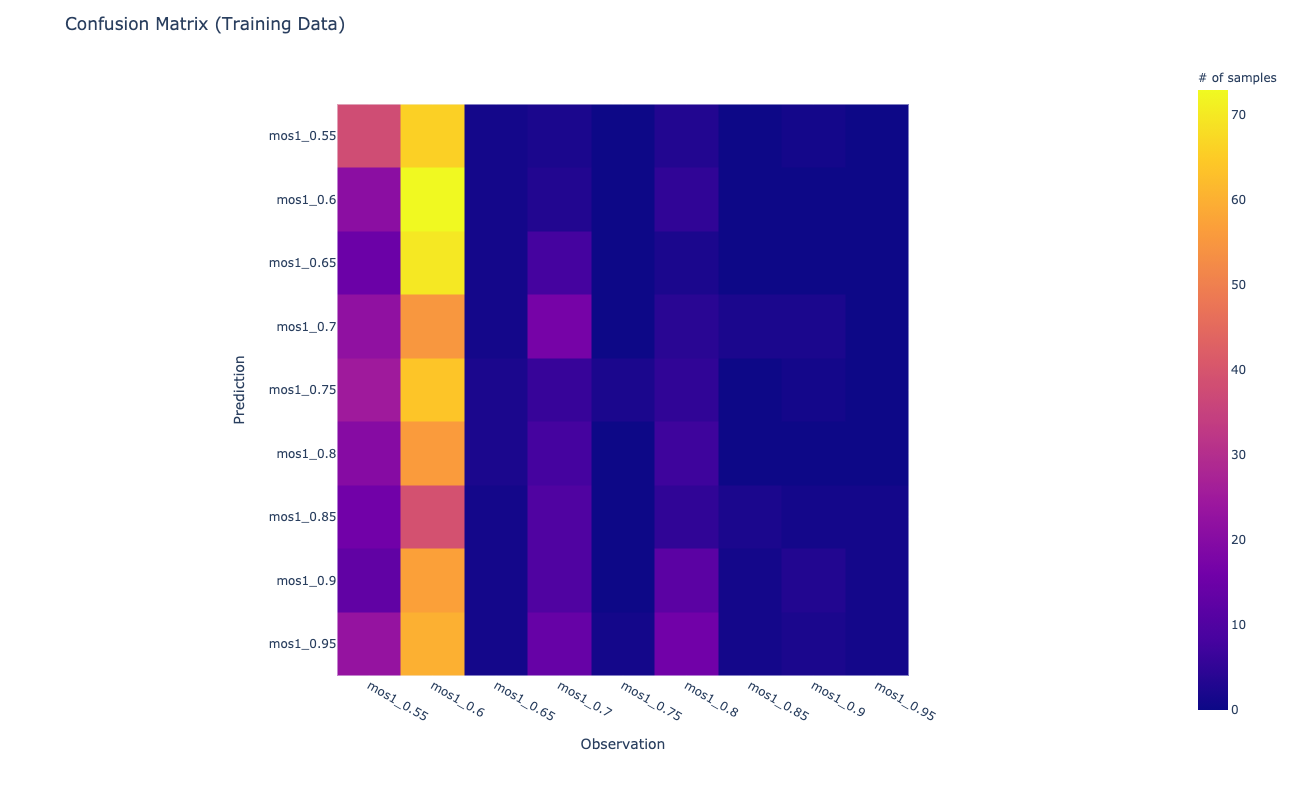

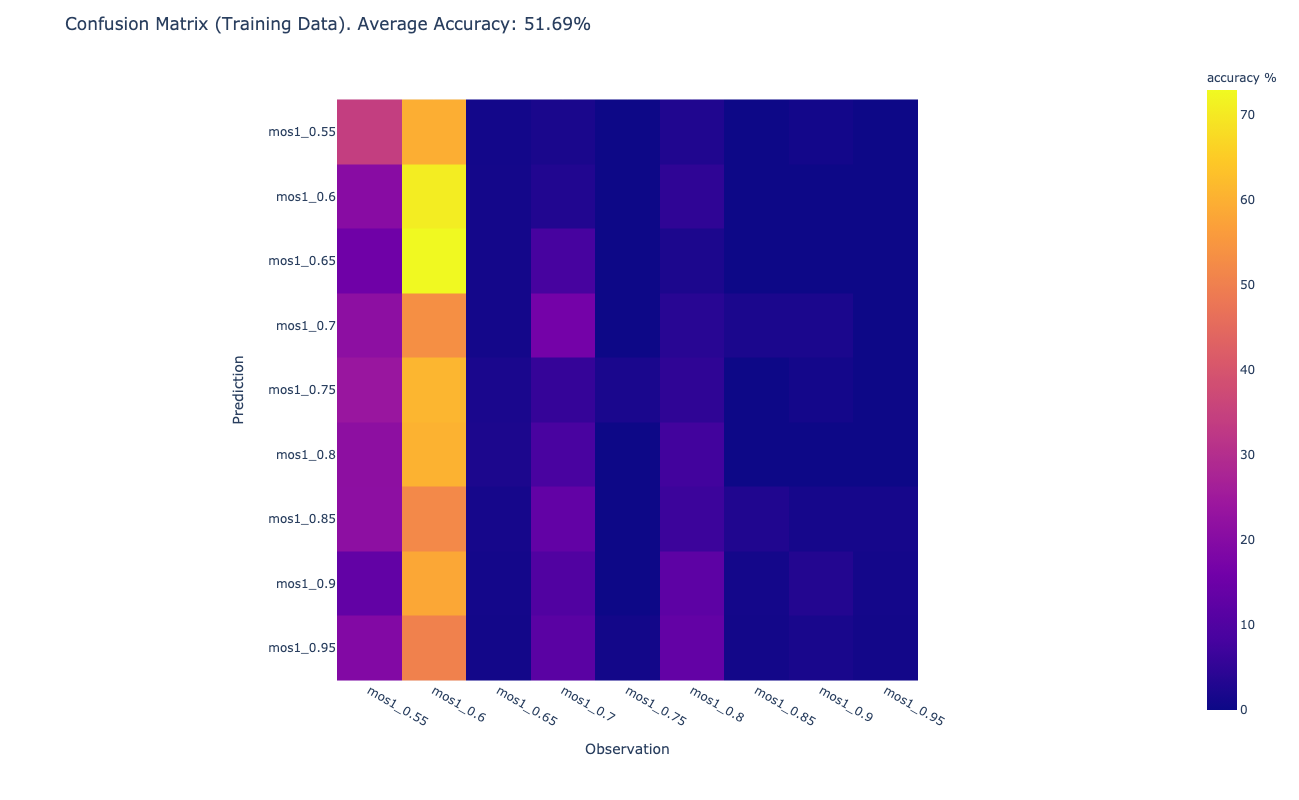

In [38]:
fig1 = px.imshow(cm_train_df, labels=dict(y="Prediction", x="Observation", color="# of samples"))
fig1.update_yaxes(dtick=1)
fig1.update_xaxes(dtick=1)
fig1.update_layout(title='Confusion Matrix (Training Data)', width=800, height=800)
fig1.show()

fig2 = px.imshow(cm_train_df2, labels=dict(y="Prediction", x="Observation", color="accuracy %"))
fig2.update_yaxes(dtick=1)
fig2.update_xaxes(dtick=1)
fig2.update_layout(title='Confusion Matrix (Training Data). Average Accuracy: {}%'.format(round(avg_train_acc, 2)), width=800, height=800)
fig2.show()